In [ ]:
#本文件是将图片提取的数据进行训练，并进行结果验证

In [66]:
import cv2
import os
import numpy as np
import math
from skimage import morphology,data,color
import matplotlib.pyplot as plt
from image_utils import *
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Reshape, BatchNormalization, TimeDistributed, Lambda, \
    Activation, LSTM, Flatten, Convolution1D, GRU, MaxPooling1D, Bidirectional
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras import initializers
from keras import backend as K
from keras.optimizers import SGD
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [67]:
raw_datas = np.load('all_datasOri.npy')
len(raw_datas),raw_datas.shape

(1456, (1456, 4))

In [68]:
midSelect,bottomSelect,vectorSelect,thickness=zip(*raw_datas)
midSelect[0][:2],bottomSelect[0][:2],vectorSelect[0][:2]

(array([[233.11577, 367.     ],
        [229.15268, 368.9052 ]], dtype=float32), array([[232, 362],
        [228, 363]], dtype=int64), array([[0.24450037, 0.9696492 ],
        [0.242426  , 0.9701699 ]], dtype=float32))

In [69]:
#因为原来像素图中的坐标是反的，所以需要调换,若以原来bottom右下角的点作为坐标原点，则：
ms=bottomSelect[0][0]-midSelect[0]
bs=bottomSelect[0][0]-bottomSelect[0]
ms=ms[:,[1,0]]
bs=bs[:,[1,0]]
vs=vectorSelect[0][:,[1,0]]*[-1,-1]
ms[:5],bs[:5],vs[:5]

(array([[ -5.        ,  -1.11576843],
        [ -6.9052124 ,   2.84732056],
        [ -8.81039429,   6.81040955],
        [ -9.        ,  10.97929382],
        [-10.99996948,  15.99125671]]), array([[ 0,  0],
        [-1,  4],
        [-2,  8],
        [-3, 12],
        [-3, 17]], dtype=int64), array([[-0.9696492 , -0.24450037],
        [-0.9701699 , -0.24242599],
        [-0.9803974 , -0.19703016],
        [-0.98287082, -0.18429591],
        [-0.99376774, -0.11147031]]))

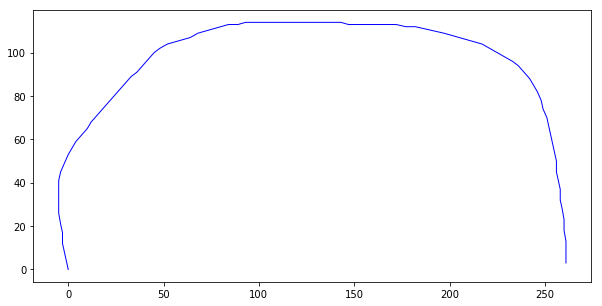

In [70]:
x,y=zip(*bs)
plt.figure(figsize=(10,5))
plt.plot(x,y,'b',linewidth=1)

In [71]:
len(thickness)

1456

135389 0.38714516619173583 4.923716733060006


(array([4.23313580e-04, 1.26668448e-02, 2.93063248e-02, 2.82578096e-01,
        2.69422812e-01, 6.19112392e-01, 4.23802019e-01, 4.98012146e-01,
        5.70496456e-01, 6.00030718e-01, 5.61541745e-01, 2.62031106e-01,
        2.33571408e-01, 3.64375305e-02, 8.53139677e-03, 1.62812915e-04,
        1.30250332e-04, 1.30250332e-04, 0.00000000e+00, 2.27938082e-04]),
 array([0.38714517, 0.61397374, 0.84080232, 1.0676309 , 1.29445948,
        1.52128806, 1.74811664, 1.97494521, 2.20177379, 2.42860237,
        2.65543095, 2.88225953, 3.10908811, 3.33591668, 3.56274526,
        3.78957384, 4.01640242, 4.243231  , 4.47005958, 4.69688815,
        4.92371673]),
 <a list of 20 Patch objects>)

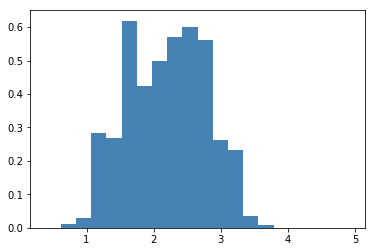

In [72]:
#数据分析，看所有的厚度分布（图上的像素点距离和实际距离比大概为一像素等于0.195cm）实际厚度太大的为异常值
all_thickness=[_t*0.195*2 for t in thickness for _t in t if _t*0.195*2 < 5]
print(len(all_thickness),min(all_thickness),max(all_thickness))
plt.hist(all_thickness, bins=20, color='steelblue', density=True )

1456 22 114


(array([0.00074654, 0.00044792, 0.00014931, 0.00014931, 0.00104515,
        0.00014931, 0.        , 0.00014931, 0.00089584, 0.00134376,
        0.00268753, 0.00447922, 0.01672241, 0.02239608, 0.01776756,
        0.03389274, 0.02209747, 0.02866699, 0.04927138, 0.01433349]),
 array([ 22. ,  26.6,  31.2,  35.8,  40.4,  45. ,  49.6,  54.2,  58.8,
         63.4,  68. ,  72.6,  77.2,  81.8,  86.4,  91. ,  95.6, 100.2,
        104.8, 109.4, 114. ]),
 <a list of 20 Patch objects>)

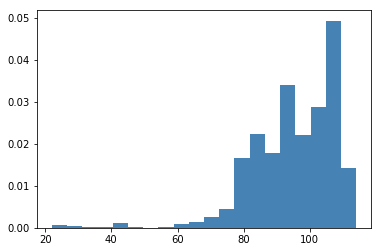

In [73]:
#数据分析，看所有的样本长度
len_thickness=[len(t) for t in thickness]
print(len(len_thickness),min(len_thickness),max(len_thickness))
plt.hist(len_thickness, bins=20, color='steelblue', density=True )

In [74]:
#符合的橡胶条数：
print(len([t for t in thickness if max(t)*0.195*2 < 5 and len(t) > 80 ]))

1239


In [75]:
#制作训练数据（取连续80个为一段，数据x:[[gradiant0,起始宽度，结尾宽度]，[gradiant1,起始宽度，结尾宽度]]
#y：[起始宽度，第二个宽度。。。结尾宽度]）
#gradiant计算方法为法线的单位向量和x轴夹角的弧度值，如果法线在x轴上方为正，下方为负
all_data=[]
test_data=[]
hw=40
#midSelect,bottomSelect,vectorSelect,thickness
for i in range(len(bottomSelect)):
    if max(thickness[i])*0.195*2 > 5:
        continue
    ms,bs,vs,tn = midSelect[i],bottomSelect[i],vectorSelect[i],thickness[i] 
    ms=bs[0]-ms
    bs=bs[0]-bs
    ms=ms[:,[1,0]]
    bs=bs[:,[1,0]]
    vs=vs[:,[1,0]]*[-1,-1]
    tn = tn*0.195*2/5*2-1 #归一化到[-1,1]
    
    gradiant=[math.acos(vx/(vx**2+vy**2)**0.5)*int(vy/abs(vy))/3.1416 if vy!=0 else 0 for vx,vy in vs]

    train_x=[]
    train_y=[]
    for j in range(hw,len(ms)-hw):
        train_x.append(gradiant[j-hw:j+hw]+[tn[j-hw]]+[tn[j+hw-1]])
        train_y.append(tn[j-hw:j+hw])
    #留下前几条作为验证
    if i <= 5:
        vms,vbs=[],[]
        for j in range(hw,len(ms)-hw):
            vms.append(ms[j-hw:j+hw])
            vbs.append(bs[j-hw:j+hw])
        test_data.append([train_x,train_y,vms,vbs])
    else:
        all_data.append([train_x,train_y])

In [76]:
X,Y=zip(*all_data)
X=np.array([_x for x in X for _x in x])
Y=np.array([_y for y in Y for _y in y])
print(X.shape,Y.shape)

(22482, 82) (22482, 80)


In [77]:
model = Sequential()
model.add(Dense(input_dim=len(X[0]), output_dim=512, activation="relu"))
# model.add(Dropout(0.5))
# model.add(Dense(output_dim=512, activation="relu"))
# model.add(Dropout(0.5))
# model.add(Dense(output_dim=512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_dim=256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_dim=len(Y[0]), activation="tanh"))

In [78]:
model.compile(loss="mse", optimizer="adam")

In [79]:
history = model.fit([X],
                     Y,
                     batch_size=16,
                     epochs=20,  
                     validation_split=0.3,
                     verbose=True,
                     shuffle=True,
                     )

Train on 15737 samples, validate on 6745 samples
Epoch 1/20
15737/15737 [==============================] - 4s 277us/step - loss: 0.0483 - val_loss: 0.0377
Epoch 2/20
15737/15737 [==============================] - 4s 231us/step - loss: 0.0393 - val_loss: 0.0343
Epoch 3/20
15737/15737 [==============================] - 4s 226us/step - loss: 0.0367 - val_loss: 0.0328
Epoch 4/20
15737/15737 [==============================] - 3s 221us/step - loss: 0.0353 - val_loss: 0.0312
Epoch 5/20
15737/15737 [==============================] - 4s 223us/step - loss: 0.0341 - val_loss: 0.0300
Epoch 6/20
15737/15737 [==============================] - 4s 230us/step - loss: 0.0332 - val_loss: 0.0297
Epoch 7/20
15737/15737 [==============================] - 4s 271us/step - loss: 0.0325 - val_loss: 0.0290
Epoch 8/20
15737/15737 [==============================] - 4s 232us/step - loss: 0.0319 - val_loss: 0.0288
Epoch 9/20
15737/15737 [==============================] - 4s 231us/step - loss: 0.0314 - val_loss: 0.02

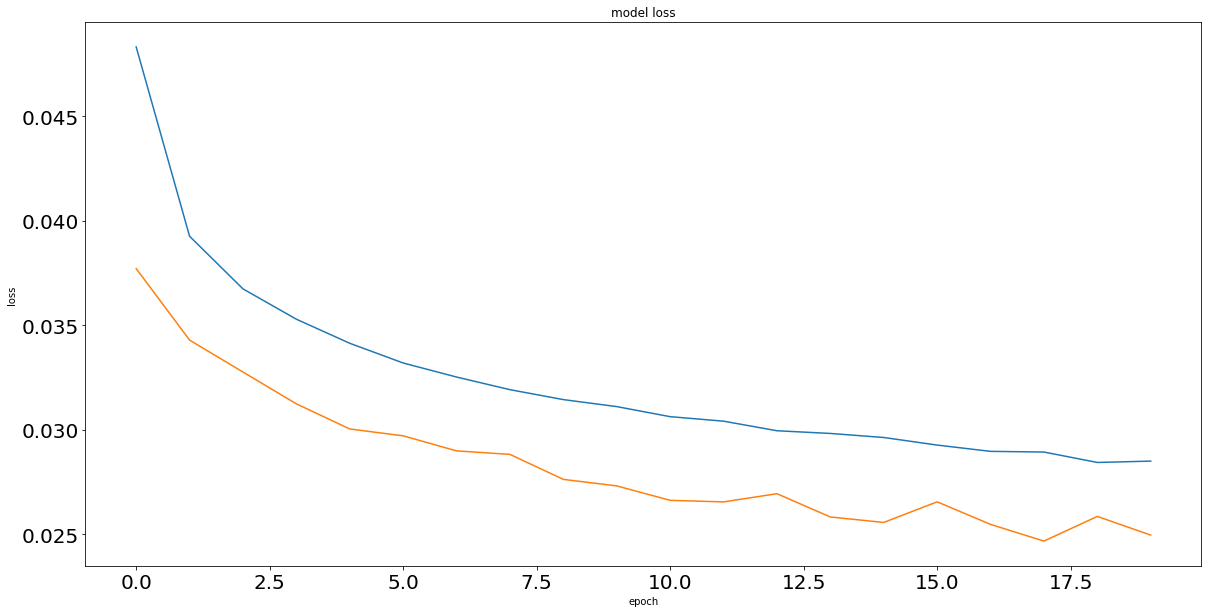

In [80]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
#查看拟合效果：
#可以从预留的test里拿数据
print(len(test_data))
for i in range(len(test_data)):
    print(len(test_data[i][0]))

6
14
8
11
21
1
26


In [20]:
test_x,test_y,test_ms,test_bs=list(zip(*test_data[3]))[20]#拿出第一条的第一段

In [21]:
test_x,test_y,test_ms,test_bs = np.array([test_x]),np.array(test_y),np.array(test_ms),np.array(test_bs)
print(test_x.shape,test_y.shape,test_ms.shape,test_bs.shape)

(1, 82) (80,) (80, 2) (80, 2)


In [22]:
#当g==0的时候vx符号会出问题，参考周围几个点的符号
def vx_sign(vx,i):
    start=max(i-5,0)
    tmp_vx=vx[start:start+10]
    if sum([_t/abs(_t) for _t in tmp_vx])>0:
        return 1
    else:return -1

In [23]:
ps = model.predict([test_x])
gradiant=np.squeeze(test_x)[:80]
ps = (np.squeeze(ps)+1)/2*5/2/0.195
ms_x,ms_y=zip(*test_ms)
bs_x,bs_y=zip(*test_bs)
vx=np.array([math.cos(abs(g)*3.1416) for g in gradiant])
for i in range(len(gradiant)):
    if gradiant[i]==0:
        vx[i] *= vx_sign(vx,i)
vy=(1-vx**2)**0.5*np.array([int(g/abs(g)) if g!=0 else 0 for g in gradiant])
ts_x=vx*ps+bs_x
ts_y=vy*ps+bs_y

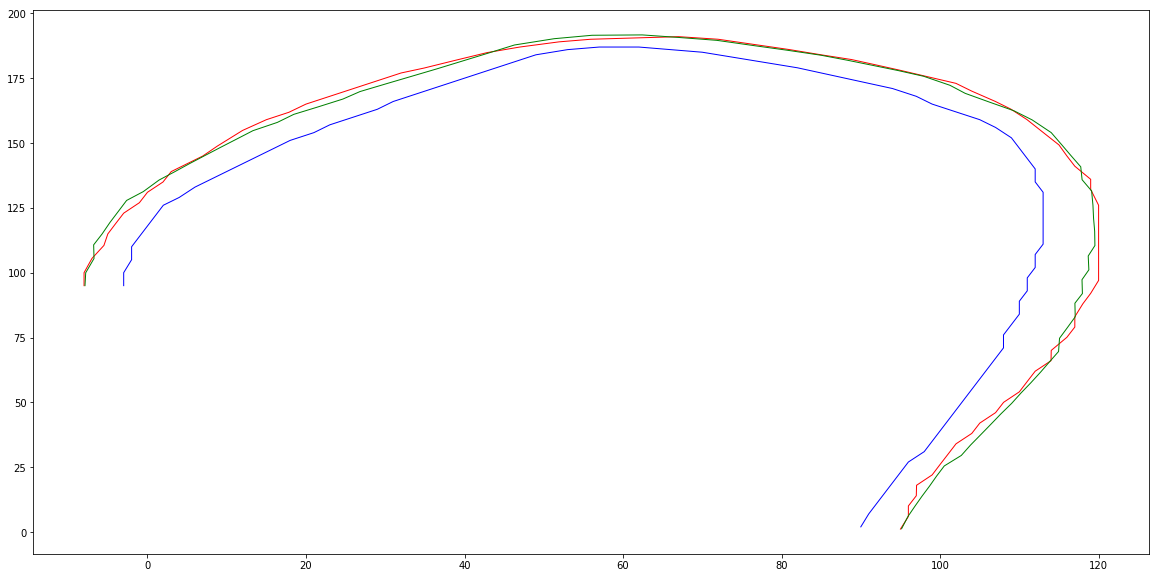

In [24]:
plt.figure(figsize=(20,10))
plt.plot(bs_x,bs_y,'b',linewidth=1)
plt.plot(ms_x,ms_y,'r',linewidth=1)
plt.plot(ts_x,ts_y,'g',linewidth=1)